In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
y = df['Count'].values 
n = len(y)

In [4]:
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [5]:
def ssa_analysis(y, L):
    """
    SSA с длиной окна L.
    Возвращает:
    - реконструированные компоненты (RC)
    - матрицу W-корреляции
    """
    N = len(y)
    K = N - L + 1
    
    # Формирование траекторной матрицы
    X = np.zeros((L, K))
    for i in range(K):
        X[:, i] = y[i:i+L]
    
    # SVD
    U, Sigma, Vt = svd(X, full_matrices=False)
    
    # Реконструированные компоненты (RC)
    RC = np.zeros((L, N))
    for k in range(min(L, len(Sigma))):
        uk = U[:, k:k+1]
        vk = Vt[k:k+1, :]
        sigma_k = Sigma[k]
        Xk = sigma_k * uk @ vk  # матрица ранга 1
        # Диагональное усреднение
        for i in range(N):
            start = max(0, i - L + 1)
            end = min(i + 1, K)
            RC[k, i] = np.mean(Xk[max(0, L-1-i):L, start:end])
    
    # Матрица W-корреляции
    W_corr = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            W_corr[i, j] = np.corrcoef(RC[i], RC[j])[0, 1]
    
    return RC, W_corr

In [6]:
L_list = [12, 24, 36]
results = {}

for L in L_list:
    RC, W_corr = ssa_analysis(y_scaled, L)
    results[L] = {'RC': RC, 'W_corr': W_corr}

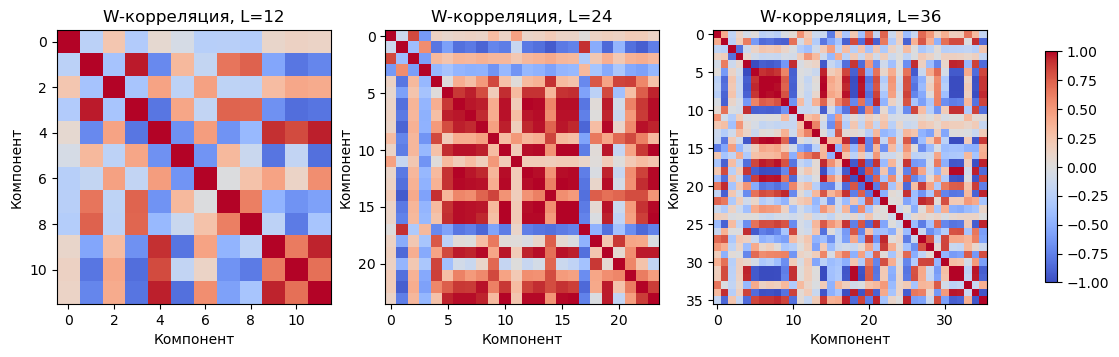

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, L in enumerate(L_list):
    im = axes[i].imshow(results[L]['W_corr'], cmap='coolwarm', vmin=-1, vmax=1)
    axes[i].set_title(f'W-корреляция, L={L}')
    axes[i].set_xlabel('Компонент')
    axes[i].set_ylabel('Компонент')
plt.colorbar(im, ax=axes, shrink=0.6)
plt.show()

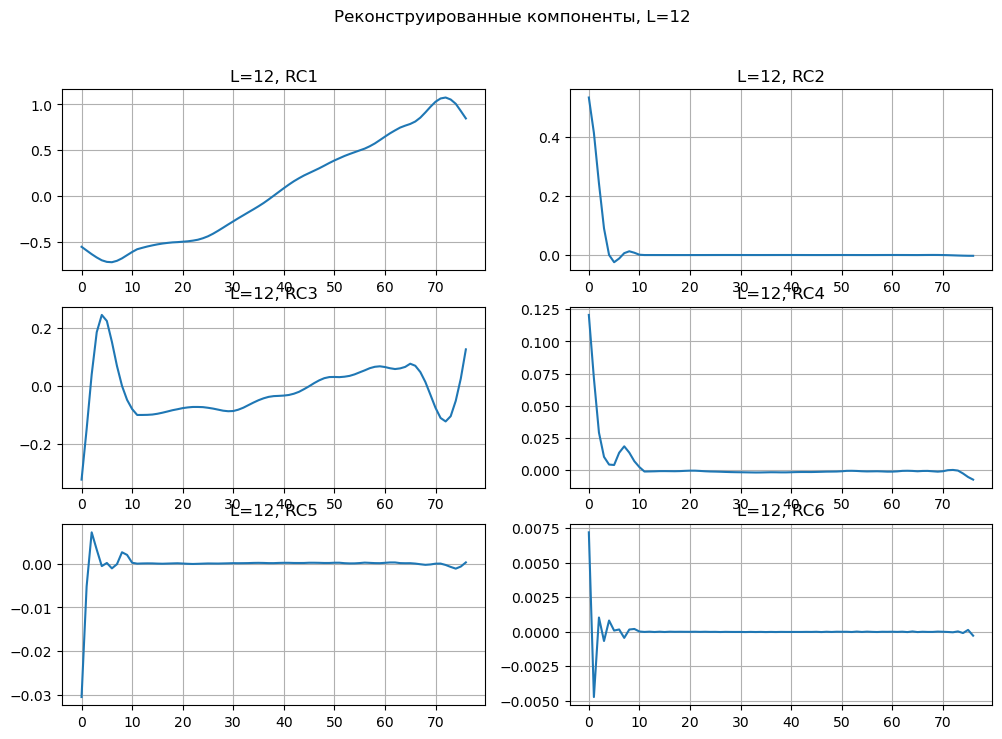

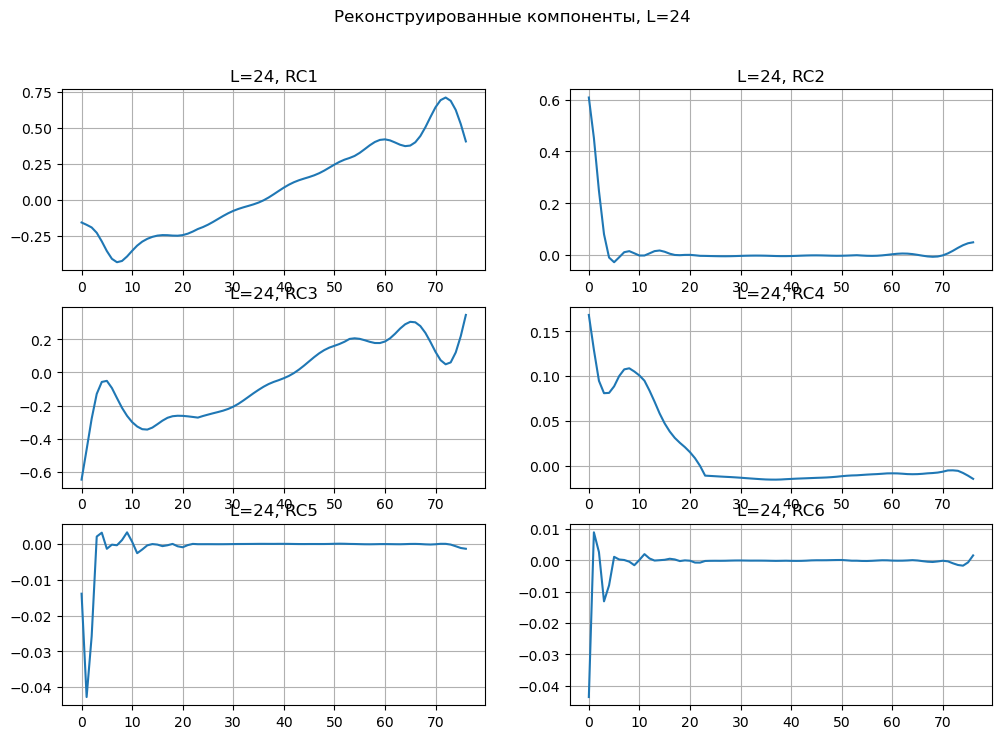

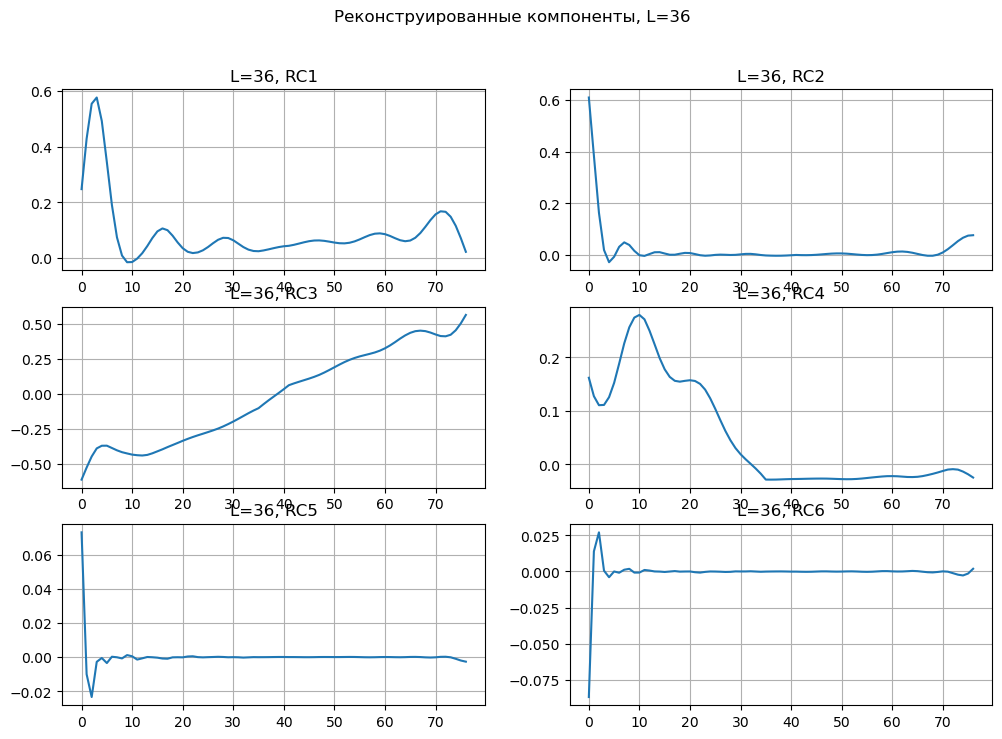

In [8]:
for L in L_list:
    RC = results[L]['RC']
    plt.figure(figsize=(12, 8))
    for k in range(6):  # первые 6 компонентов
        plt.subplot(3, 2, k+1)
        plt.plot(RC[k], label=f'RC{k+1}')
        plt.title(f'L={L}, RC{k+1}')
        plt.grid(True)
    plt.suptitle(f'Реконструированные компоненты, L={L}')
    plt.show()

In [10]:
for L in L_list:
    RC = results[L]['RC']
    # Сумма первых 4 компонентов (тренд + сезонность)
    y_recon = np.sum(RC[:4], axis=0)
    rmse = np.sqrt(mean_squared_error(y_scaled, y_recon))
    print(f'L={L}, RMSE (первые 4 RC): {rmse:.4f}')

L=12, RMSE (первые 4 RC): 0.7887
L=24, RMSE (первые 4 RC): 0.8117
L=36, RMSE (первые 4 RC): 0.9195


Для ряда продаж компании X оптимальный размер окна L = 24.

Это позволяет чётко выделить тренд, годовую сезонность и возможные среднесрочные циклы, минимизируя переобучение.